# Homework 2

### 1. 对上次作业提供的单细胞测序数据pmbc_data.csv，采取autoencoder作为降维方法，训练超参数自选，用表格中提供的细胞类型作为颜色画出散点图（4分）
For the single-cell sequencing data pmbc_data.csv provided in the last assignment, use an autoencoder as the dimensionality reduction method. Select your own training hyperparameters, and then create a scatter plot, coloring the data points by the cell types provided in the table (4 points).

### Data Preprocessing

In [2]:
import pandas as pd

file_path = "./pbmc_data.csv"
pbmc_data = pd.read_csv(file_path)
pbmc_data.head()

,Unnamed: 0,TNFRSF4,CPSF3L,ATAD3C,C1orf86,RER1,TNFRSF25,TNFRSF9,CTNNBIP1,SRM,...,BACE2,SIK1,C21orf33,ICOSLG,SUMO3,SLC19A1,S100B,PRMT2,cell_type,cell_type_string
0,AAACATACAACCAC-1,-0.171470,-0.280812,-0.046677,-0.475169,-0.544024,4.928497,-0.038028,-0.280573,-0.341788,...,-0.102943,-0.222116,-0.312401,-0.121678,-0.521229,-0.098269,-0.209095,-0.531203,0,CD4 T
1,AAACATTGAGCTAC-1,-0.214582,-0.372653,-0.054804,-0.683391,0.633951,-0.334837,-0.045589,-0.498264,-0.541914,...,0.007155,-0.445372,1.629285,-0.058662,-0.857163,-0.266844,-0.313146,-0.596654,2,B
2,AAACATTGATCAGC-1,-0.376888,-0.295085,-0.057527,-0.520972,1.332648,-0.309362,-0.103108,-0.272526,-0.500799,...,-0.071774,-0.297857,-0.410920,-0.070431,-0.590720,-0.158656,-0.170876,1.379000,0,CD4 T
3,AAACCGTGCTTCCG-1,-0.285241,-0.281735,-0.052227,-0.484929,1.572680,-0.271825,-0.074552,-0.258875,-0.416752,...,-0.093818,-0.247770,2.552079,-0.097402,1.631684,-0.119462,-0.179120,-0.505669,1,CD14 Monocytes
4,AAACCGTGTATGCG-1,-0.256484,-0.220394,-0.046800,-0.345859,-0.333409,-0.208122,-0.069514,5.806440,-0.283112,...,-0.167350,-0.098665,-0.275836,-0.139482,-0.310095,-0.006877,-0.109614,-0.461946,4,NK


In [3]:
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from numpy.typing import NDArray

torch.manual_seed(42)

features: NDArray[np.float32] = pbmc_data.iloc[:, 1:-2].values
cell_types: pd.Series = pbmc_data['cell_type_string']

scaler = MinMaxScaler()
features_scaled: NDArray[np.float32] = scaler.fit_transform(features)
features_tensor = torch.FloatTensor(features_scaled)



### Define Autoencoder model

In [4]:
import torch.nn as nn
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int) -> None:
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 512),
            nn.Tanh(),
            nn.Linear(512, input_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

### Train the model

In [5]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.adam import Adam

input_dim = features_scaled.shape[1]
latent_dim = 2
model = Autoencoder(input_dim, latent_dim)

optimizer = Adam(
    model.parameters(),
    lr=0.001
)

criterion = nn.MSELoss()

dataset = TensorDataset(features_tensor, features_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_features, _ in dataloader:
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')



Epoch [1/20], Loss: 0.0110
Epoch [2/20], Loss: 0.0098
Epoch [3/20], Loss: 0.0097
Epoch [4/20], Loss: 0.0097
Epoch [5/20], Loss: 0.0097
Epoch [6/20], Loss: 0.0097
Epoch [7/20], Loss: 0.0097
Epoch [8/20], Loss: 0.0096
Epoch [9/20], Loss: 0.0096
Epoch [10/20], Loss: 0.0096
Epoch [11/20], Loss: 0.0096
Epoch [12/20], Loss: 0.0096
Epoch [13/20], Loss: 0.0095
Epoch [14/20], Loss: 0.0096
Epoch [15/20], Loss: 0.0095
Epoch [16/20], Loss: 0.0096
Epoch [17/20], Loss: 0.0095
Epoch [18/20], Loss: 0.0095
Epoch [19/20], Loss: 0.0095
Epoch [20/20], Loss: 0.0095


In [6]:
from numpy.typing import NDArray
model.eval()
with torch.no_grad():
    latent_representations: NDArray[np.float32] = model.encode(features_tensor).numpy()

### Visualize the results

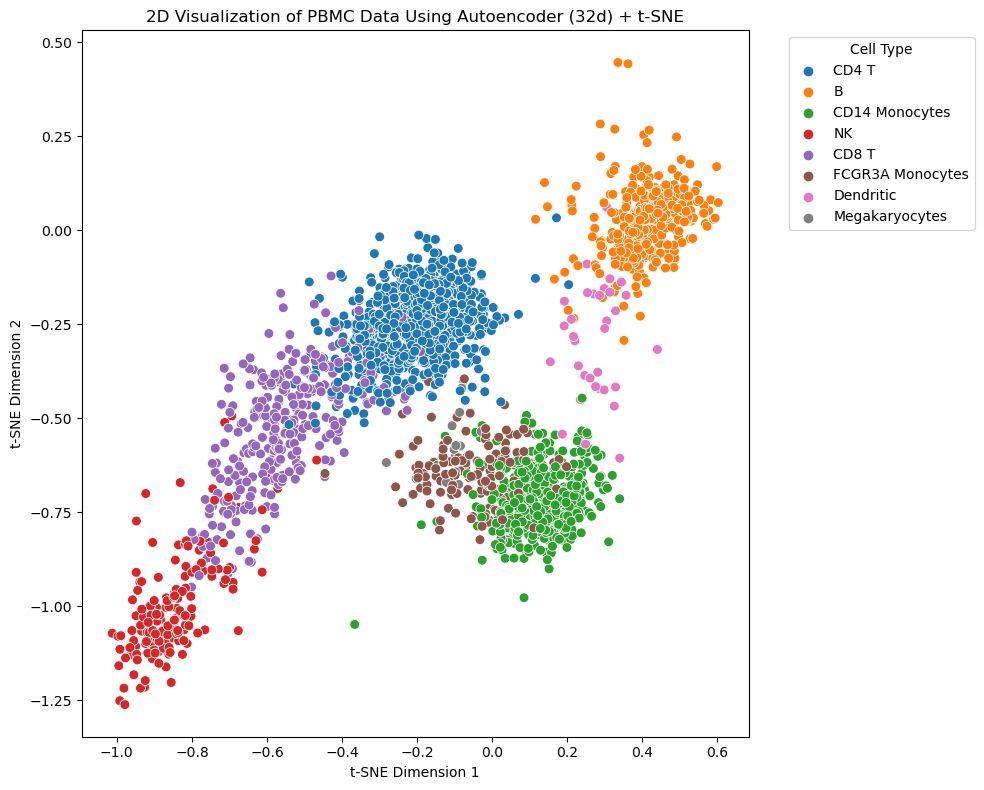

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=latent_representations[:, 0],
    y=latent_representations[:, 1],
    hue=cell_types,
    palette="tab10",
    s=50
)
plt.title("2D Visualization of PBMC Data Using Autoencoder (32d) + t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 3. 构建神经网络模型，通过细胞的基因表达预测细胞的类型，要求在网络结构（如深度、宽度、Batchnorm层、Resnet结构等等）和训练优化器中，至少各变动一次超参数，对最终超参数对应的模型（至少四个）进行合理的评估比较。在Notebook中，用“文本”详细描述评估的依据和结论，不少于300字（6分）

### Data Preprocessing

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, AdamW
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Data Preprocessing
file_path = "./pbmc_data.csv"
data = pd.read_csv(file_path)

# Features and Labels
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # The last column is the cell type

# Remove non-numeric columns
X = X.select_dtypes(include=[np.number])
X = X.values.astype(np.float32)  # Convert to float32 type

# Label Encoding  
le = LabelEncoder()
y = le.fit_transform(y).astype(np.int64)  # Ensure labels are int64 type

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert to tensors
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

### 1.Base Model

In [74]:
class BaseModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(BaseModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 2.DeepBN Model

In [75]:
class DeepBNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(DeepBNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, num_classes)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

### 3. Wide Model


In [76]:
class WideModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(WideModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*2)
        self.bn1 = nn.BatchNorm1d(hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, num_classes)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### 4.ResNet Model

In [77]:
class ResNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(ResNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        identity = self.fc1(x)
        x = F.relu(self.bn1(identity))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x += identity
        x = self.fc3(x)
        return x

### Train and evaluate the model

In [80]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        avg_train_loss = train_loss/len(train_loader)
        avg_val_loss = val_loss/len(val_loader)
        train_accuracy = 100 * train_correct / train_total
        val_accuracy = 100 * val_correct / val_total
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = model.state_dict().copy()
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
            print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

# Get input dimension and number of classes
input_dim = X.shape[1]
num_classes = len(np.unique(y))

print(f"Input dimension: {input_dim}")
print(f"Number of classes: {num_classes}")

# Create model instances
models = {
    'Base': BaseModel(input_dim, 128, num_classes),
    'DeepBN': DeepBNModel(input_dim, 128, num_classes),
    'Wide': WideModel(input_dim, 128, num_classes),
    'ResNet': ResNetModel(input_dim, 128, num_classes)
}

# Optimizer configuration
optimizers = {
    'SGD': lambda params: SGD(params, lr=0.01, momentum=0.9),
    'AdamW': lambda params: AdamW(params, lr=0.001, weight_decay=0.01)
}

# Train and evaluate
results = {}
criterion = nn.CrossEntropyLoss()

for model_name, model in models.items():
    for opt_name, opt_fn in optimizers.items():
        print(f"\nTraining {model_name} with {opt_name}")
        optimizer = opt_fn(model.parameters())        
        model_results = train_and_evaluate(
            model, train_loader, val_loader, optimizer, criterion
        )
        
        results[f"{model_name}_{opt_name}"] = model_results
        print(f"Best validation accuracy: {model_results['best_val_acc']:.2f}%")

Input dimension: 1839
Number of classes: 8

Training Base with SGD
Epoch [10/50]
Train Loss: 0.0022, Train Acc: 100.00%
Val Loss: 0.0881, Val Acc: 96.21%
Epoch [20/50]
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.0876, Val Acc: 96.68%
Epoch [30/50]
Train Loss: 0.0006, Train Acc: 100.00%
Val Loss: 0.0879, Val Acc: 96.92%
Epoch [40/50]
Train Loss: 0.0004, Train Acc: 100.00%
Val Loss: 0.0886, Val Acc: 97.16%
Epoch [50/50]
Train Loss: 0.0003, Train Acc: 100.00%
Val Loss: 0.0892, Val Acc: 97.39%
Best validation accuracy: 97.39%

Training Base with AdamW
Epoch [10/50]
Train Loss: 0.0000, Train Acc: 100.00%
Val Loss: 0.1025, Val Acc: 95.97%
Epoch [20/50]
Train Loss: 0.0000, Train Acc: 100.00%
Val Loss: 0.1033, Val Acc: 95.97%
Epoch [30/50]
Train Loss: 0.0000, Train Acc: 100.00%
Val Loss: 0.1043, Val Acc: 95.97%
Epoch [40/50]
Train Loss: 0.0000, Train Acc: 100.00%
Val Loss: 0.1053, Val Acc: 95.97%
Epoch [50/50]
Train Loss: 0.0000, Train Acc: 100.00%
Val Loss: 0.1061, Val Acc: 95.73%
Best

### Visualize Result

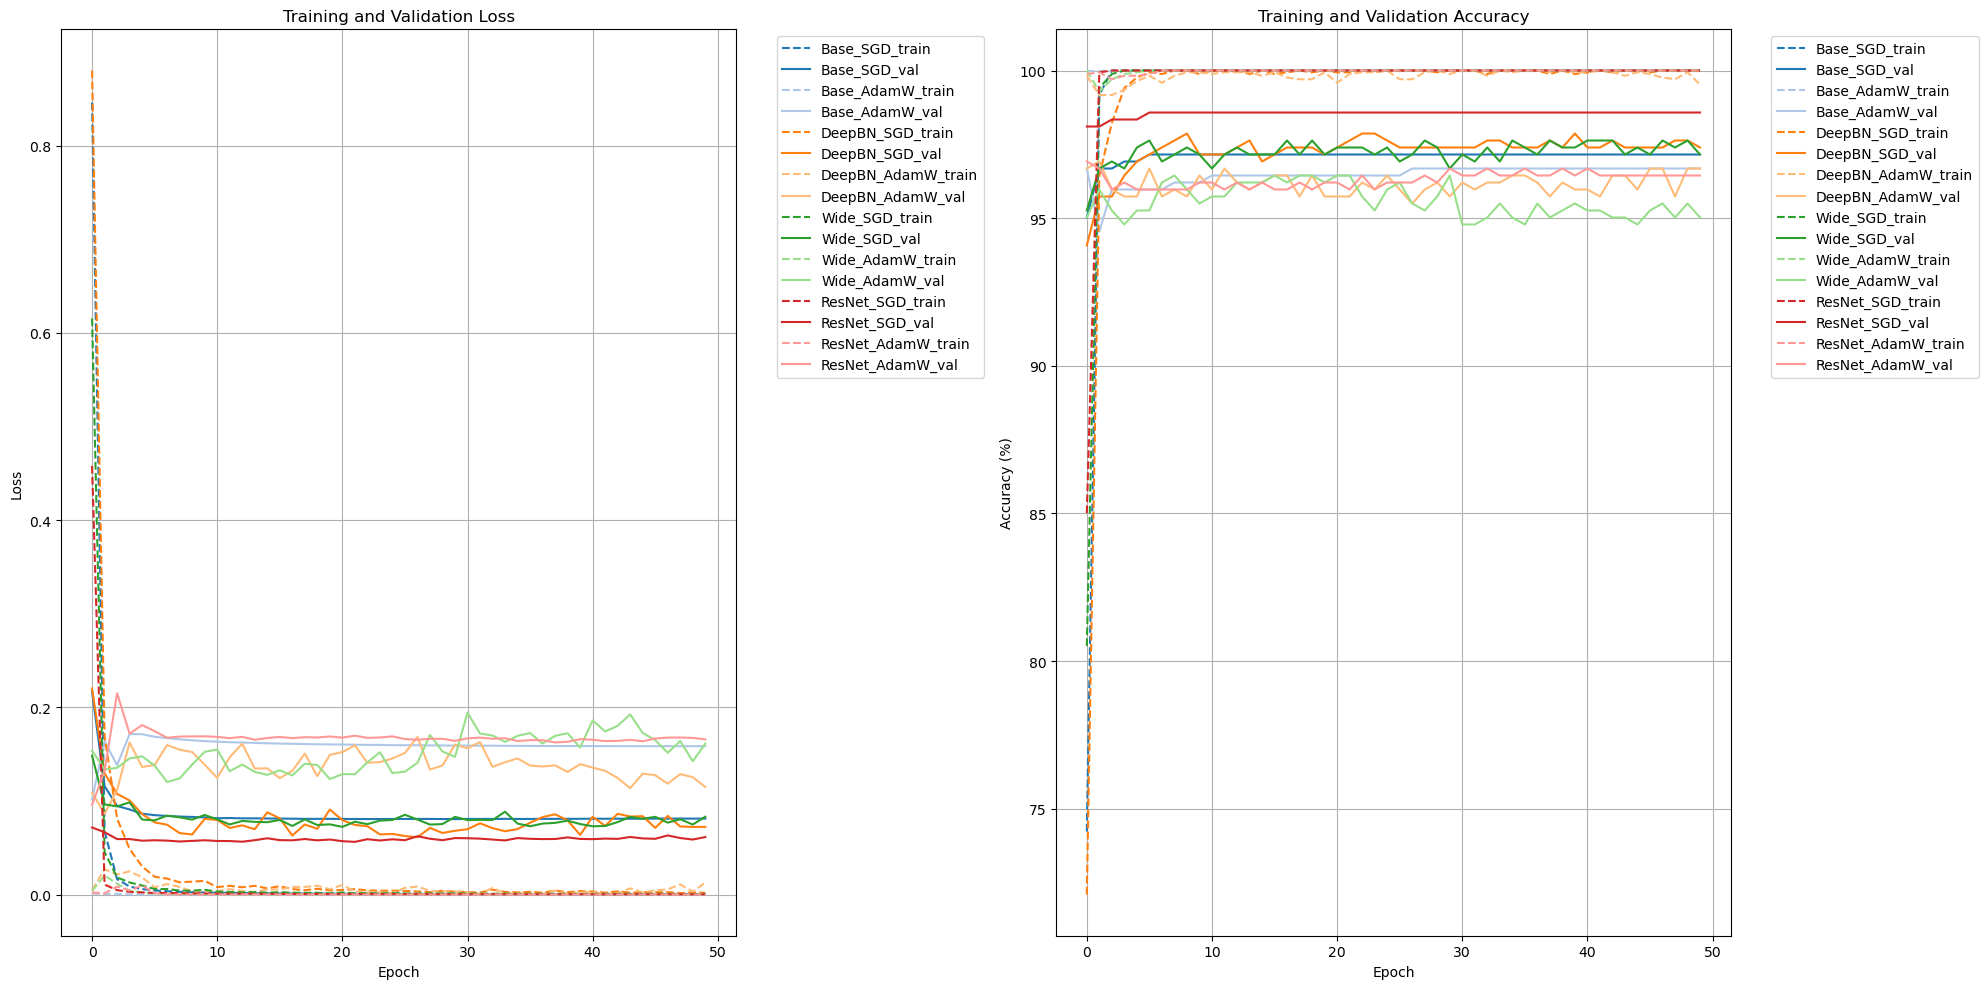


Detailed Results Summary:
--------------------------------------------------

Model: Base_SGD
Best Validation Accuracy: 97.16%
Final Training Loss: 0.0003
Final Validation Loss: 0.0811
Final Training Accuracy: 100.00%
Final Validation Accuracy: 97.16%
--------------------------------------------------

Model: Base_AdamW
Best Validation Accuracy: 96.68%
Final Training Loss: 0.0000
Final Validation Loss: 0.1584
Final Training Accuracy: 100.00%
Final Validation Accuracy: 96.68%
--------------------------------------------------

Model: DeepBN_SGD
Best Validation Accuracy: 97.87%
Final Training Loss: 0.0018
Final Validation Loss: 0.0723
Final Training Accuracy: 100.00%
Final Validation Accuracy: 97.39%
--------------------------------------------------

Model: DeepBN_AdamW
Best Validation Accuracy: 96.92%
Final Training Loss: 0.0127
Final Validation Loss: 0.1149
Final Training Accuracy: 99.53%
Final Validation Accuracy: 96.68%
--------------------------------------------------

Model: Wid

In [79]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(20, 10))

colors = plt.cm.tab20.colors

# Loss curve
plt.subplot(1, 2, 1)
for i, (name, result) in enumerate(results.items()):
    plt.plot(result['train_losses'], '--', label=f'{name}_train', color=colors[i % len(colors)])
    plt.plot(result['val_losses'], '-', label=f'{name}_val', color=colors[i % len(colors)])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
for i, (name, result) in enumerate(results.items()):
    plt.plot(result['train_accs'], '--', label=f'{name}_train', color=colors[i % len(colors)])
    plt.plot(result['val_accs'], '-', label=f'{name}_val', color=colors[i % len(colors)])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# Show results
print("\nDetailed Results Summary:")
print("-" * 50)
for name, result in results.items():
    print(f"\nModel: {name}")
    print(f"Best Validation Accuracy: {result['best_val_acc']:.2f}%")
    print(f"Final Training Loss: {result['train_losses'][-1]:.4f}")
    print(f"Final Validation Loss: {result['val_losses'][-1]:.4f}")
    print(f"Final Training Accuracy: {result['train_accs'][-1]:.2f}%")
    print(f"Final Validation Accuracy: {result['val_accs'][-1]:.2f}%")
    print("-" * 50)

在这次实验中，我们构建了多种神经网络模型，通过细胞的基因表达数据预测细胞类型。在网络结构和训练优化器中分别变动了超参数，并根据验证集和训练集的loss和accuracy对四个模型进行了评估和比较。
#### 评估比较结果
##### 损失和准确率：
从图中可以看到，所有模型在训练初期损失迅速下降，准确率迅速上升。最终loss和accuracy的表现均非常优秀，每个模型的差异并不大。

##### 模型比较：

1. Base模型
    
    训练损失迅速下降至接近0，训练准确率达到100%；验证损失和准确率都较为稳定，表现良好；SGD和AdamW表现相近，但SGD略优

2. DeepBN模型
    
    训练损失下降平稳，训练准确率高；验证损失和准确率都比较稳定，但后续不再增加，出现过拟合。整体较稳定，可能是BatchNorm的使用使然。

3. Wide模型
    
    训练损失下降较快，但后期有波动；验证损失在后期有上升趋势，准确率略有下降。说明存在较严重的过拟合，特别是在训练后期。

4. ResNet模型
    
    训练损失持续下降，训练准确率高；验证损失较高，但准确率维持在较高水平。说明残差连接帮助模型保持了较好的性能。


##### 优化器比较：
SGD整体表现略优于AdamW，但不同模型对优化器的敏感度不同。

#### 结论
1. 所有模型都存在一定程度的过拟合，训练准确率达到100%，验证准确率升高到一定程度后不再上升。使用dropout策略可能可以进行进一步改进。

2. Base模型和DeepBN模型整体表现最好，验证损失最低，验证准确率稳定且高。

3. 模型稳定性：DeepBN > Base > ResNet > Wide

4. 有时候简单的模型（如Base模型）可能比复杂的模型表现更好，关键是要找到适合特定任务的模型结构和优化策略。





